In [1]:
# Download the dataset
!echo "Downloading 101_Object_Categories for image notebooks"

!curl -L -o 101_ObjectCategories.zip --progress-bar https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1
!unzip 101_ObjectCategories.zip
!mv caltech-101/101_ObjectCategories.tar.gz ./101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls

######################################################################### 100.0%##O=#  #                                                                                                             7.3%
Archive:  101_ObjectCategories.zip
   creating: caltech-101/
  inflating: __MACOSX/._caltech-101  
  inflating: caltech-101/101_ObjectCategories.tar.gz  
  inflating: __MACOSX/caltech-101/._101_ObjectCategories.tar.gz  
  inflating: caltech-101/show_annotation.m  
  inflating: __MACOSX/caltech-101/._show_annotation.m  
  inflating: caltech-101/Annotations.tar  
  inflating: __MACOSX/caltech-101/._Annotations.tar  
101_ObjectCategories  101_ObjectCategories.zip	caltech-101  __MACOSX


In [9]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import random
import os

# Defining the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
])

# Loading the dataset
dataset_path = "101_ObjectCategories"  
dataset = ImageFolder(root=dataset_path, transform=transform)

img,label=dataset[1]
print(img.shape,label)

torch.Size([3, 224, 224]) 0


In [17]:
# Selecting a subset for faster processing
n_images = 1000  # num images to keep in the dataset.
random_indices = random.sample(range(len(dataset)), n_images)
images_subset = Subset(dataset, random_indices)

# Use a Dataloader
batch_size = 64  
image_loader = DataLoader(images_subset, batch_size, shuffle=False, num_workers=2)

images,labels=next(iter(image_loader))
print(images.shape,labels)

torch.Size([64, 3, 224, 224]) tensor([  6,   4,  81,  20,  17,   9,  82,  95,  24,   1,  74,  59,   6,   6,
         70,   6,  14,  95,  45,   1,  66,  52,  59,   4,   0,  94,  15,   6,
         10,  24,  37,  43,  32,  47, 100,  76,  14,   4,  11,   0,   6,   6,
          4,  38,  56,  97,   0,  38,  54,  52,   6,  50, 101,  82,  73,  65,
          4,  66,  76,   1,  33,  51,   2,  54])


## **Feature Extraction using EfficientNetV2-S**
using a **pretrained EfficientNetV2-S model** and modify it to **extract features before classification**.


In [12]:
import torch
from torchvision import models
import torch.nn as nn
from tqdm import tqdm

# Loading the pretrained EfficientNetV2-S model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
model.eval().to(device)

# Modify EfficientNetV2-S to extract features before classification
def extract_features(image_tensor):
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        features = model.features(image_tensor)  # Extract features
        features = torch.flatten(features, start_dim=1)  # Flatten before passing to classifier
        # features = efficientnet.classifier[0](features)  # Pass through first layer of classifier
    return features

# Extract features for all images
all_features = []
image_tensors = []

for images, _ in tqdm(image_loader):
    image_tensors.append(images)
    features = extract_features(images)
    all_features.append(features.cpu())

# Convert to numpy
all_features = torch.cat(all_features).numpy()
image_tensors = torch.cat(image_tensors)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 171MB/s] 
100%|██████████| 16/16 [00:05<00:00,  3.06it/s]


In [18]:
print(all_features.shape)
print(image_tensors.shape)

(1000, 62720)
torch.Size([1000, 3, 224, 224])


## **Applying PCA for Dimensionality Reduction**
Since **EfficientNetV2-S outputs high-dimensional features**, we apply **PCA** to reduce dimensions and speed up search.


In [19]:
from sklearn.decomposition import PCA

# Apply PCA
n_pca_components = 300  # Number of principal components to keep
pca = PCA(n_components=n_pca_components)
pca_features = pca.fit_transform(all_features)

In [20]:
pca_features.shape

(1000, 300)

## **Image Retrieval using Cosine Similarity**

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import torch
import random

# Select a random query image
random_idx = random.randint(0, len(pca_features) - 1)
query_image = image_tensors[random_idx]
query_features = pca_features[random_idx]

print(query_image.shape)
print(query_features.shape)

torch.Size([3, 224, 224])
(300,)


In [23]:
# Compute cosine similarity
similarities = cosine_similarity(pca_features, query_features.reshape(1, -1)).reshape(-1)

# Get top 5 similar images
top_indices = similarities.argsort()[-6:-1][::-1]  # Ignore query itself and do reversing to get 
                                                   # the highest similarities first

print(top_indices)

[907   8 946 743 333]


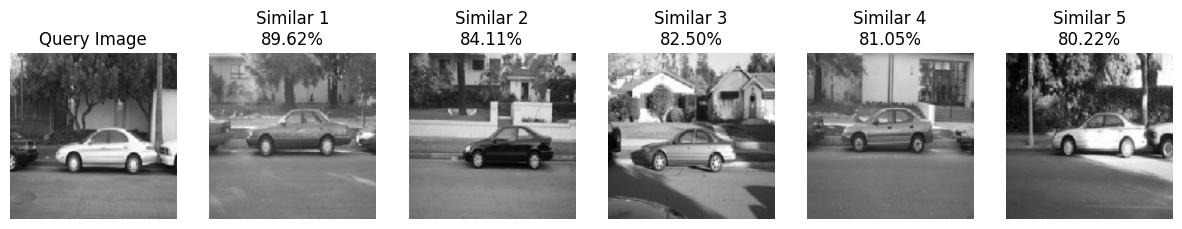

In [25]:
# Displaying query & retrieved images with similarity scores
fig, axes = plt.subplots(1, 6, figsize=(15, 3))

# Query image
axes[0].imshow(query_image.permute(1, 2, 0).numpy())
axes[0].set_title("Query Image")
axes[0].axis("off")

# Retrieved similar images with similarity scores
for i, idx in enumerate(top_indices):
    image = image_tensors[idx]
    similarity_score = similarities[idx]  # Get similarity score
    axes[i + 1].imshow(image.permute(1, 2, 0).numpy())
    axes[i + 1].set_title(f"Similar {i+1}\n{100*similarity_score:.2f}%")  # Show similarity score
    axes[i + 1].axis("off")

plt.show()


# (❁´◡`❁) 🔥🚀